In [15]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip
import seaborn as sns

% matplotlib inline
%load_ext autoreload
% autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data= pd.read_csv('/data/Good data_store.csv')
data.head()

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
0,2016072704,27,3,0,0,0,1,"26,27,28,29","31,32,33,34,35,36",1,0,NaN,50Hz IE preonly
1,2017021501,30,3,0,0,0,2,"12,13","16,17",1,0,NaN,50Hz IE preonly
2,2016091403,30,2,0,0,0,1,"14,15","17,18",1,1,NaN,50Hz IE preonly
3,2017062202,24,1,0,0,0,1,"30,31,32","34,35",1,0,"No change, good data",50Hz IE preonly
4,2016072902,29,1,0,1,0,0,43,"45,46,47,48,49",1,0,NaN,50Hz IE preonly


In [17]:
cd /data

/data


In [18]:
data['Ptl_note'].value_counts()

50Hz EI preonly         12
E_I_2Hz_associative     12
50Hz EI high freq       12
EI_antihebbian          10
50Hz EI postonly        10
EI_low high             10
50Hz IE postonly         9
50Hz IE preonly          9
E_I_2Hz_Associ_2AG       8
50Hz IE high freq        8
E_I_2Hz_POST_2AG         7
E_I_preonly_low          7
No ptl                   7
E_i_postsynapti_low      6
EI_high_low              5
50Hz II high freq        5
 Naspm 100 uM            5
IE_high_low              4
IE_high low              4
Naspm 100 uM             2
50 Hz II preonly         1
50 hZ II preonly         1
pre only after Naspm     1
Name: Ptl_note, dtype: int64

In [19]:
data_pre_50Hz_reci = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==1)]
data_pre_50Hz_uni = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==0)]

In [20]:
data_pre_50Hz_reci

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
14,2016091201,28,2,1,1,0,1,"16,17,18","21,22,23,24,25",2,13,NaN,50Hz EI preonly
15,2016100201,26,1,1,1,0,2,"3,4","6,7,8",2,0,NaN,50Hz EI preonly
16,2016100303,27,1,1,1,0,2,"4,5","8,9,10,11,12",2,7,Increased PPR,50Hz EI preonly
17,2016100304,27,2,1,1,0,2,11,"13,14,15,16",2,4,"Reduced onset tau, incrased decay tau",50Hz EI preonly
18,2017021302,30,1,0,1,0,2,5,"7,8,9,10",2,0,Increased onset tau,50Hz EI preonly
19,2017053101,34,2,1,1,1,1,"5,6","8,9",2,18,NaN,50Hz EI preonly


In [21]:
# Process all the before trial
isi=1   # Use only the 100 ms
trial_output = {}

data_tmp = data_pre_50Hz_reci
for j in range(len(data_pre_50Hz_reci)):
    test_name = str(int(data_tmp['File name'].iloc[j]))
    if len(test_name)==12:
        test_name = test_name[:-2]
    test_name = 'test'+ test_name
    test_data = sio.loadmat(test_name)
    test_pip = data_tmp.iloc[j]['Pip number']
    test_trace_idx_bef = data_tmp.iloc[j]['Trial number before']
    test_trace_idx_aft = data_tmp.iloc[j]['Trial number after']
    ifartifact = data_tmp.iloc[j]['Artifact']
    isi = data_tmp.iloc[j]['IS100']
    bef_index = [int(s)-1 for s in str.split(test_trace_idx_bef, ',')]
    aft_index = [int(s)-1 for s in str.split(test_trace_idx_aft, ',')]
    trial_output[data_pre_2Hz_reci.index[j]]= patch_pip.bef_aft_ana(trial=test_data['test'][0], bef_index=bef_index, aft_index=aft_index, test_pip=test_pip, isi=isi, ifartifact=ifartifact, ave_len=3,  iffigure=0)

pre_50Hz_reci = pd.DataFrame(trial_output, index=['Before', 'After']).transpose()
pre_50Hz_reci['File name'] = data['File name']
pre_50Hz_reci.to_pickle('pre_50Hz_reci')

In [22]:
pre_50Hz_reci = pd.read_pickle('pre_50Hz_reci')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


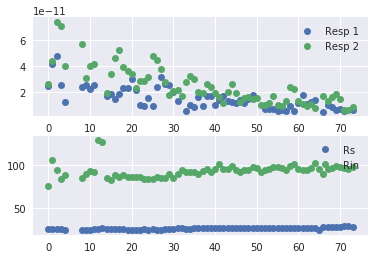

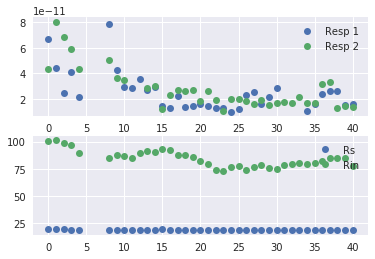

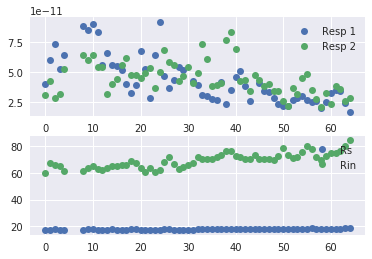

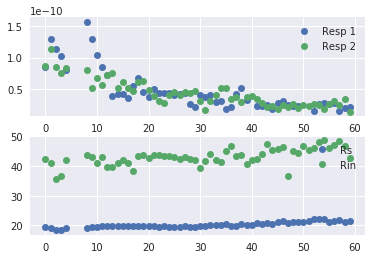

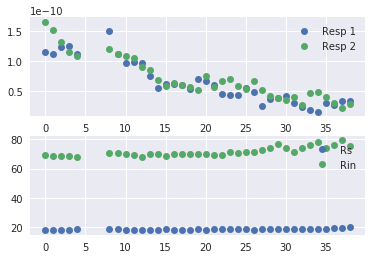

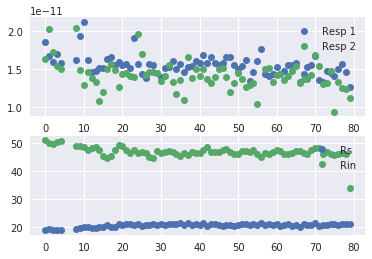

In [23]:
data_ana = pre_50Hz_reci
ave_ptl_resp = np.zeros((len(pre_50Hz_reci), 60))

for i in range(len(pre_50Hz_reci)):
    bef_amp1 = data_ana.iloc[i]['Before']['ave_amp1'][-5:]
    aft_amp1 = data_ana.iloc[i]['After']['ave_amp1']
    bef_amp2 = data_ana.iloc[i]['Before']['ave_amp2'][-5:]
    aft_amp2 = data_ana.iloc[i]['After']['ave_amp2']
    bef_rs = data_ana.iloc[i]['Before']['rs'][-5:]
    aft_rs = data_ana.iloc[i]['After']['rs']
    bef_ir = data_ana.iloc[i]['Before']['ir'][-5:]
    aft_ir = data_ana.iloc[i]['After']['ir']
    rs_joint= np.concatenate([bef_rs, np.ones((3,1))*np.nan, aft_rs])
    ir_joint= np.concatenate([bef_ir, np.ones((3,1))*np.nan, aft_ir])
    resp1_joint= np.concatenate([bef_amp1, np.ones((3,1))*np.nan, aft_amp1])
    resp2_joint = np.concatenate([bef_amp2, np.ones((3,1))*np.nan, aft_amp2])
    ave_ptl_resp[i,:5] = bef_amp1[-5:].reshape(1,-1)
    end_trace = np.min((48, len(aft_amp1)))
    ave_ptl_resp[i,12:12+end_trace] = aft_amp1[:end_trace].reshape(1,-1)
    plt.figure()
    fig, ax = plt.subplots(2,1)
    ax[0].plot(resp1_joint, 'o', label='Resp 1')
    ax[0].plot(resp2_joint, 'o', label='Resp 2')
    ax[0].legend(loc='upper right')
    ax[1].plot(rs_joint, 'o', label='Rs')
    ax[1].plot(ir_joint, 'o', label='Rin')
    ax[1].legend(loc='upper right')
    
ave_ptl_mean = np.nanmean(ave_ptl_resp, axis=0)
ave_ptl_ste = np.nanstd(ave_ptl_resp, axis=0)/np.sqrt(i)

<Container object of 3 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


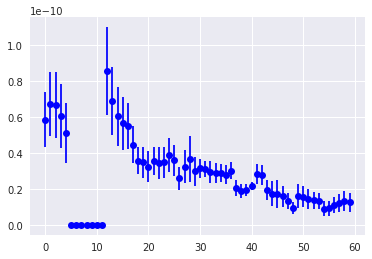

In [24]:
plt.errorbar(x=np.arange(len(ave_ptl_mean)), y=ave_ptl_mean, yerr=ave_ptl_ste, fmt='bo')

In [25]:
elimi = np.array([60,40,60, 55,35,60,])
elimi_sr = pd.Series(elimi, index=pre_50Hz_reci.index)
pre_50Hz_reci['elimi']=elimi_sr

In [26]:
pre_50Hz_reci.to_pickle('pre_50Hz_reci')